---
title: "Exploring and Implementing the Perceptron"
author: "Yahya Rahhawi"
date: "2025-03-23"
categories: [Machine Learning]
format:
  html:
    toc: true
    code-fold: false
---

### Abstract

This blog post explores the implementation and behavior of the perceptron algorithm, a foundational model in machine learning for binary classification. I begin by building the perceptron from scratch using PyTorch, including custom classes for the model, loss computation, and optimization steps. Through a series of visual experiments, I demonstrate that the perceptron converges when the data is linearly separable, and fails to do so otherwise. I also extend the analysis to higher-dimensional data, using PCA to visualize the decision boundary. This post highlights both the capabilities and limitations of the perceptron, setting the stage for more advanced linear models.  
You can find my implementation of the perceptron at [this GitHub link](https://github.com/yahyarahhawi/yahyarahhawi.github.io/blob/main/posts/Exploring-Perceptrom/perceptron.py).

In [17]:
%load_ext autoreload
%autoreload 2
from perceptron import Perceptron, PerceptronOptimizer


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data Generation and Visualization

First, let's generate and visualize 2D synthetic data for testing the perceptron algorithm. The `perceptron_data()` function creates a binary classification dataset with Gaussian noise and appends a bias term to each data point. The `plot_perceptron_data()` function displays the two classes using distinct markers and colors.

Functions provided by Professor Phil Chodrow as part of CSCI 0451 course materials.

This setup provides a visual way to assess whether the perceptron correctly learns to separate the two classes in later experiments.

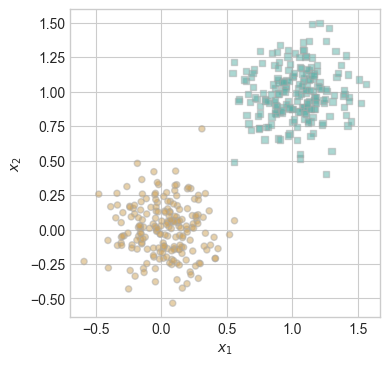

In [130]:
import torch
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

torch.manual_seed(1234)

def perceptron_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)

    # convert y from {0, 1} to {-1, 1}
    
    return X, y

X, y = perceptron_data(n_points = 300, noise = 0.2)

def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

def plot_perceptron_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = 2*y[ix]-1, facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

fig, ax = plt.subplots(1, 1, figsize = (4, 4))
X, y = perceptron_data(n_points =  400, noise = 0.2)
plot_perceptron_data(X, y, ax)



### Training the Perceptron

Now, let's define and run the `train_perceptron()` function, which trains a perceptron model on the synthetic dataset using the Perceptron update rule. The function samples one random data point per iteration, checks if it's misclassified, and updates the model if necessary. The training continues either until convergence (zero loss) or until the specified maximum number of iterations is reached.

If `visualize=True`, the function also displays a sequence of plots showing how the decision boundary evolves as the model learns. Dashed lines represent the previous boundary before an update, and solid lines show the updated one. The logic is also adapted from Professor Chodrow's work.


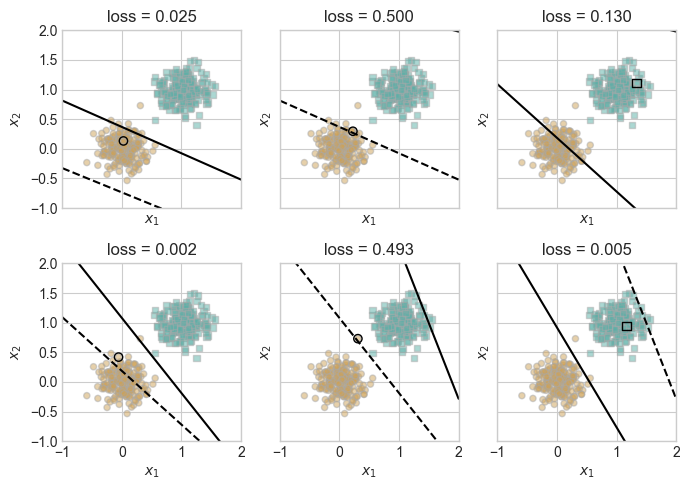

In [131]:
def train_perceptron(X, y, max_iter=1_000_000, visualize=False, max_axes=6):
    """
    Train a perceptron on the given data.

    Parameters:
        X (torch.Tensor): Input features of shape (n_samples, 3)
        y (torch.Tensor): Binary labels (0 or 1) of shape (n_samples,)
        max_iter (int): Maximum number of iterations to run (-1 means run until convergence)
        visualize (bool): If True, visualize decision boundary evolution
        max_axes (int): Number of subplots to show if visualizing

    Returns:
        p (Perceptron): Trained perceptron model
        opt (PerceptronOptimizer): Optimizer used for training
        loss_vec (list): Loss values over training steps
    """

    p = Perceptron()
    opt = PerceptronOptimizer(p)

    n = X.size(0)
    loss_vec = []

    # Trigger initialization of p.w by calling score once
    _ = p.score(X)

    loss = 1.0
    iteration = 0
    current_ax = 0

    if visualize:
        fig, axarr = plt.subplots(2, 3, sharex=True, sharey=True)
        plt.rcParams["figure.figsize"] = (7, 5)
        markers = ["o", ","]
        marker_map = {-1: 0, 1: 1}

    while loss > 0 and (max_iter == -1 or iteration < max_iter):
        old_w = torch.clone(p.w)

        # Sample one data point
        i = torch.randint(n, size=(1,))
        x_i = X[[i], :]
        y_i = y[i]
        local_loss = p.loss(x_i, y_i).item()

        # If misclassified, update and optionally visualize
        if local_loss > 0:
            opt.step(x_i, y_i)
            loss = p.loss(X, y).item()
            loss_vec.append(loss)

            if visualize and current_ax < max_axes:
                ax = axarr.ravel()[current_ax]
                plot_perceptron_data(X, y, ax)
                draw_line(old_w, x_min=-1, x_max=2, ax=ax, color="black", linestyle="dashed")
                draw_line(p.w, x_min=-1, x_max=2, ax=ax, color="black")
                ax.scatter(
                    X[i, 0],
                    X[i, 1],
                    color="black",
                    facecolors="none",
                    edgecolors="black",
                    marker=markers[marker_map[2 * y[i].item() - 1]],
                )
                ax.set_title(f"loss = {loss:.3f}")
                ax.set(xlim=(-1, 2), ylim=(-1, 2))
                current_ax += 1

        iteration += 1

    if visualize:
        plt.tight_layout()
        plt.show()

    return p, opt, loss_vec

p, opt, loss_vec = train_perceptron(X, y, visualize=True, max_iter= 100000)

### Results: Convergence of the Perceptron Algorithm

The plots above show the progression of the perceptron’s decision boundary during training on linearly separable 2D data. Each subplot corresponds to a misclassified point that triggered an update. The dashed line represents the previous decision boundary, while the solid line shows the updated one after a single perceptron step.

As training proceeds, the loss steadily decreases until it reaches zero, indicating perfect classification on the dataset. This confirms that the perceptron algorithm converges when the data is linearly separable, as expected from the theory.

let's make sure that we indeed do get 0 loss at the end

In [132]:
loss_vec[-1]

0.0

Let us now visualize the loss vector to see how it updates over time!

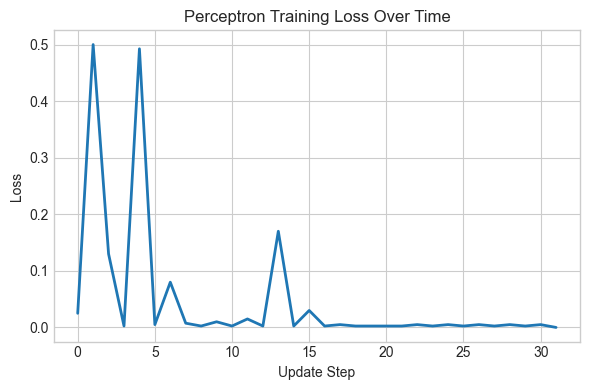

In [133]:
# Plotting the evolution of loss during training
plt.figure(figsize=(6, 4))
plt.plot(loss_vec, linewidth=2)
plt.xlabel("Update Step")
plt.ylabel("Loss")
plt.title("Perceptron Training Loss Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()

The loss indeed converges to zero with some spikes along the way!

### Introducing a Misclassified Point

now, I will modify the dataset to make it linearly inseparable by manually injecting a single mislabeled data point. This new point at `(0, 0.5)` is assigned to class `1`, but is positioned among points from class `0`. As a result, no straight line can perfectly separate the two classes.

This visualization sets up the next experiment to test how the perceptron behaves when perfect classification is impossible.

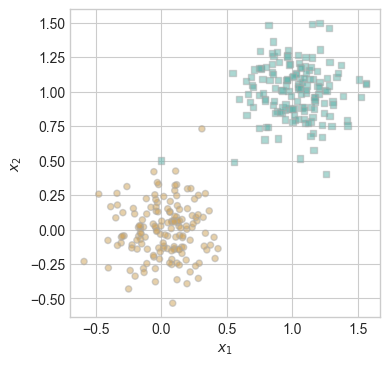

In [ ]:
#injecting one data point to make the data linearly inseparable

X_ , y_ = X, y
X_ = torch.cat((X_, torch.tensor([[0, 0.5, 1.0]])), dim=0)
y_ = torch.cat((y_, torch.tensor([True])), dim=0)
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
plot_perceptron_data(X_, y_, ax)


Let's retrain on the linearly inseparable data and get it to run for 10000 iterations

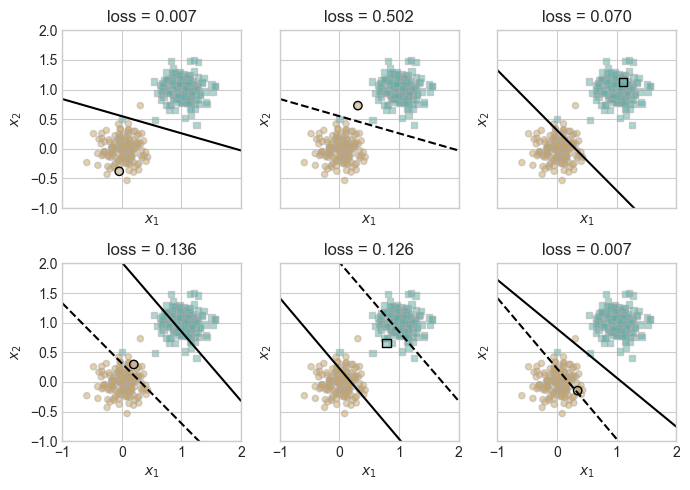

In [134]:
p, opt, loss_vec = train_perceptron(X_, y_, visualize=True, max_iter= 10000)

In [137]:
loss_vec[-1]

0.006644518114626408

The final loss after training is approximately 0.0066, indicating that while the perceptron was able to correctly classify most data points, it could not achieve perfect accuracy due to the presence of the injected outlier. This aligns with theoretical expectations: the perceptron algorithm cannot converge to zero loss on linearly inseparable data.

### Perceptron in Higher Dimensions

To explore how the perceptron performs in higher dimensions, I generated a 5-dimensional dataset using the same `perceptron_data()` function. The model was then trained for a maximum of 10,000 iterations. The resulting loss plot shows that the perceptron consistently reduced the misclassification rate over time, suggesting that the data is likely linearly separable in this higher-dimensional space.

Since visualizing 5D data directly is not possible, I used Principal Component Analysis (PCA) to project the data into 2D for visualization. Additionally, I approximated the perceptron’s decision boundary (a 4D hyperplane) by sampling points that satisfy the hyperplane equation and projecting them into the same 2D space using PCA.

The resulting plot shows a clear separation between the two classes in the projected space, with the projected hyperplane aligning well between them. This demonstrates that the perceptron is capable of finding meaningful separating boundaries even in higher-dimensional feature spaces.

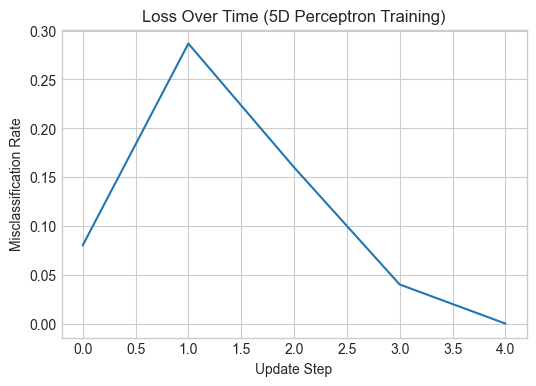

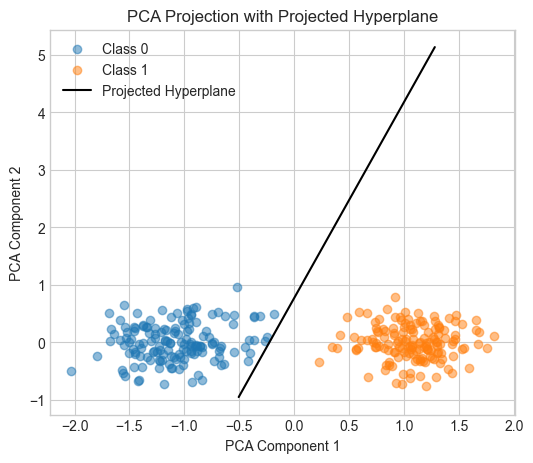

In [139]:
from sklearn.decomposition import PCA

# Step 1: Generate data
X_hd, y_hd = perceptron_data(n_points=300, noise=0.3, p_dims=5)

# Step 2: Train perceptron
p_hd, opt_hd, loss_vec_hd = train_perceptron(X_hd, y_hd, max_iter=10000, visualize=False)

# Step 3: Plot loss over time
plt.figure(figsize=(6, 4))
plt.plot(loss_vec_hd)
plt.xlabel("Update Step")
plt.ylabel("Misclassification Rate")
plt.title("Loss Over Time (5D Perceptron Training)")
plt.grid(True)
plt.show()

# Step 4: PCA fit (exclude bias column)
X_hd_np = X_hd[:, :-1].numpy()
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_hd_np)

# Step 5: Project a sample of points on the decision hyperplane
# We pick random 5D points x such that w·x + b ≈ 0
w = p_hd.w[:-1]
b = p_hd.w[-1]

# Sample points along the hyperplane by solving w·x + b = 0
# Fix all but one dimension and solve for the last
x_vals = []
for i in range(-5, 6):  # varying x0 from -5 to 5
    x_sample = torch.zeros(5)
    x_sample[0] = i
    # solve for x1 such that the hyperplane condition is met
    # w0*x0 + w1*x1 + ... + w4*x4 + b = 0
    # → x1 = -(b + w0*x0 + w2*x2 + ...)/w1
    # we'll keep x2, x3, x4 = 0 for simplicity
    if w[1] != 0:
        x_sample[1] = -(b + w[0]*x_sample[0]) / w[1]
        x_vals.append(x_sample.numpy())

# Convert to numpy and apply PCA
x_vals = np.stack(x_vals)
x_vals_pca = pca.transform(x_vals)

# Step 6: Plot PCA projection of data and separating line
plt.figure(figsize=(6, 5))
plt.scatter(X_pca[y_hd==0][:, 0], X_pca[y_hd==0][:, 1], label="Class 0", alpha=0.5)
plt.scatter(X_pca[y_hd==1][:, 0], X_pca[y_hd==1][:, 1], label="Class 1", alpha=0.5)
plt.plot(x_vals_pca[:, 0], x_vals_pca[:, 1], color='black', label="Projected Hyperplane")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Projection with Projected Hyperplane")
plt.legend()
plt.grid(True)
plt.show()

### Conclusion

In this notebook, I implemented the perceptron algorithm from scratch and explored its behavior through a series of experiments. I confirmed that the perceptron converges on linearly separable data and fails to fully converge when the data is not perfectly separable. Visualizations of the decision boundary and loss trajectory provided insight into how the model evolves with each update. I also extended the analysis to higher-dimensional data and used PCA to visualize the model's decision hyperplane, showing that the perceptron remains effective in separating classes beyond two dimensions. Overall, these experiments reinforce both the strengths and limitations of the perceptron algorithm, providing a solid foundation for understanding more advanced linear classifiers.